In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn import linear_model
from numpy.linalg import inv
# from models import LassoBandit, DRLassoBandit, SALassoBandit

In [2]:
def sample_spherical(N, k):
    vec = np.random.randn(k, N)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

def sample_elliptical(N, d, k, mu):
    S = sample_spherical(N, k)
    A = np.random.rand(d,k)
    R = np.random.normal(size=N)
    return mu + A.dot(R*S)

def SMInv(Ainv, u, v):
    return Ainv - np.dot(Ainv, np.dot(np.outer(u,v), Ainv)) / ( 1 + np.dot(v, np.dot(Ainv, u)))


def random_ball(num_points, dimension, radius=1):
    from numpy import random, linalg
    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball).
    random_directions = random.normal(size=(dimension,num_points))
    random_directions /= linalg.norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = random.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    return radius * (random_directions * random_radii).T, 

In [3]:

class linUCB:
    def __init__(self,sigma,d,lam):
        self.d=d
        self.x=[]
        self.r=[]
        self.sigma=sigma
        self.lam = lam
        self.theta=np.zeros(d)
        self.Vinv=1/lam*np.identity(d)
        
    def choose_a(self,t,x):  # x is N*d matrix
        self.alpha = self.sigma*np.sqrt(2*self.d*np.log(t**2+t**3/self.lam)) + np.sqrt(self.lam)
        means = np.dot(x,self.theta)
        xv = np.sqrt((np.matmul(x, self.Vinv) * x).sum(axis = 1))
        u = means + self.alpha * xv
        self.action=np.argmax(u)
        xt = x[self.action]
        self.x.append(xt)
        self.Vinv = SMInv(self.Vinv, xt, xt)
        return(self.action)

    def update_beta(self,rwd,t):
        self.r.append(rwd)
        if t>3:
            model=linear_model.Ridge(alpha=self.lam)
            model.fit(self.x,self.r)
            self.theta=model.coef_
            

class linTS:
    def __init__(self,sigma,d,lam):
        self.d=d
        self.x=[]
        self.r=[]
        self.sigma=sigma
        self.lam = lam
        self.theta=np.zeros(d)
        self.Vinv=1/lam*np.identity(d)
        
    def choose_a(self,t,x):  # x is N*d matrix
        self.alpha = self.sigma*np.sqrt(self.d*np.log(self.lam+t)+d*np.log(self.lam) + 4*np.log(t)) + np.sqrt(self.lam)
        theta_tilde = np.random.multivariate_normal(self.theta, np.square(self.alpha)*self.Vinv)
        means = np.dot(x,theta_tilde)
        self.action=np.argmax(means)
        xt = x[self.action]
        self.x.append(xt)
        self.Vinv = SMInv(self.Vinv, xt, xt)
        return(self.action)

    def update_beta(self,rwd,t):
        self.r.append(rwd)
        if t>3:
            model=linear_model.Ridge(alpha=self.lam)
            model.fit(self.x,self.r)
            self.theta=model.coef_


class linGreedy:
    def __init__(self,sigma,d,lam):
        self.d=d
        self.x=[]
        self.r=[]
        self.theta=np.zeros(d)
        self.lam = lam
        
    def choose_a(self,t,x):  # x is N*d matrix
        means = np.dot(x,self.theta)
        self.action=np.argmax(means)
        xt = x[self.action]
        self.x.append(xt)
        return(self.action)

    def update_beta(self,rwd,t):
        self.r.append(rwd)
        if t>3:
            model=linear_model.Ridge(alpha=self.lam)
            model.fit(self.x,self.r)
            self.theta=model.coef_


In [5]:
#simulation settings

K=50
d=10
R=0.1
T=1000
dist = 0

sigma_sq=1.
rho_sq=0.0
V=(sigma_sq-rho_sq)*np.eye(K) + rho_sq*np.ones((K,K))


fixed = 1 # 1:fix the context set; 0: allow contexts to be drawn iid in each round


In [6]:
simul_n=4

if dist == 0:
    x=np.random.multivariate_normal(np.zeros(K),V,d).T
    x=x/np.sqrt(d)
elif dist == 1:
#     x=(np.random.random((K, d)) * 2 - 1)
    x = np.asarray(random_ball(K,d,radius=5)).reshape((K, d))
elif dist == 2:
#     x=sample_elliptical(K, d, int(d/2), 0).T
    x = np.random.standard_t(10, size=K*d).reshape((K, d))
elif dist == 3:
    x = np.random.laplace(loc, scale, K*d).reshape((K, d))

sim_start = 1
for simul in range(sim_start, sim_start+simul_n+1):
    
    beta=np.random.uniform(0.1,1.,d)/np.sqrt(d)
    
    print(simul)
    
    if fixed == 1:
        savename = "results/linBandit_N={}_d={}_rho={}_dist={}_id={}_fixed.csv".format(K, d, rho_sq, dist, simul)
    else:
        savename = "results/linBandit_N={}_d={}_rho={}_dist={}_id={}.csv".format(K, d, rho_sq, dist, simul)
    
    cumulated_regret_linUCB=[]
    cumulated_regret_linTS=[]
    cumulated_regret_Greedy=[]

    models = []
    models.append(linUCB(sigma=R,d=d,lam = 0.5))
    models.append(linTS(sigma=R,d=d,lam = 0.5))
    models.append(linGreedy(sigma=R,d=d,lam = 0.5))
    
    num_models = len(models)
    
    cumulated_regret = [ [] for _ in range(num_models) ]
    rewards = [ [] for _ in range(num_models) ]
    optRWD=list()
    
    for t in range(1,T+1):
        if (t % 100)==0:
            print(t)
                
        if fixed == 0:
            if dist == 0:
                x=np.random.multivariate_normal(np.zeros(K),V,d).T
                x=x/np.sqrt(d)
            elif dist == 1:
                x=(np.random.random((K, d)) * 2 - 1)
            elif dist == 2:
                x=sample_elliptical(K, d, int(d/2), 0).T

        err=R*np.random.randn()

        for m in range(num_models):
            a = models[m].choose_a(t+1,x)
            mean_rwd = np.dot(x[a],beta)
            rwd= mean_rwd + err
            rewards[m].append(mean_rwd)
            models[m].update_beta(rwd,t+1)

        optRWD.append(np.amax(np.dot(x,beta)))
        
    for m in range(num_models):
        cumulated_regret[m].append(np.cumsum(optRWD)-np.cumsum(rewards[m]))
    
    regret = np.vstack(cumulated_regret)
    np.savetxt(savename, regret, delimiter=",")

1
100
200
300
400
500
600
700
800
900
1000
2
100
200
300
400
500
600
700
800
900
1000
3
100
200
300
400
500
600
700
800
900
1000
4
100
200
300
400
500
600
700
800
900
1000
5
100
200
300
400
500
600
700
800
900
1000


In [7]:
# d=5
# rho_sq=0.0
reg_list = []
for i in range(1,simul_n+1):
    if fixed == 1: 
        reg_list.append(np.genfromtxt(
            'results/linBandit_N={}_d={}_rho={}_dist={}_id={}_fixed.csv'.format(K, d, rho_sq, dist, i), delimiter=','))
    else:
        reg_list.append(np.genfromtxt(
            'results/linBandit_N={}_d={}_rho={}_dist={}_id={}.csv'.format(K, d, rho_sq, dist, i), delimiter=','))
        
total_reg = np.stack(reg_list)

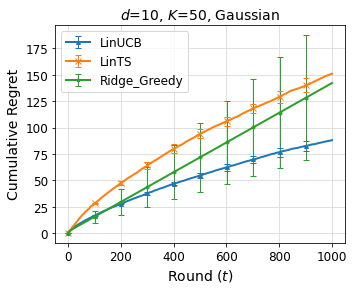

In [8]:
fig = plt.figure(figsize=(5.2, 4))
plt.style.use('default')

steps=np.arange(1,T+1)
freq = int(T/10)

avg_reg = total_reg.mean(axis=0)
sd_req = total_reg.std(axis=0)

# plt.errorbar(steps, avg_reg, sd_req, errorevery=freq, marker='^', markevery=freq, label='linUCB', markersize=4, linewidth=2, elinewidth=1, capsize=3)

plt.errorbar(steps, avg_reg[0,:], sd_req[0,:], errorevery=freq, marker='^', markevery=freq, label='LinUCB', markersize=4, linewidth=2, elinewidth=1, capsize=3)
plt.errorbar(steps, avg_reg[1,:], sd_req[1,:], errorevery=freq, marker='x', markevery=freq, label='LinTS', linewidth=2, elinewidth=1, capsize=3)
plt.errorbar(steps, avg_reg[2,:], sd_req[2,:], errorevery=freq, marker='.', markevery=freq, label='Ridge_Greedy', linewidth=2, elinewidth=1, capsize=3)
# plt.errorbar(steps, avg_reg[2,:], sd_req[2,:], errorevery=freq, marker='.', markevery=freq, label=r'$\epsilon$-Greedy + $\ell_1 + 1/T$', linewidth=2, elinewidth=1, capsize=3)


# plt.grid(True)
plt.grid(color='0.85')
plt.xlabel('Round ($t$)', size = 14)
plt.ylabel('Cumulative Regret', size = 14)
if rho_sq == 0.0:
    plt.title(r'$d$={}, $K$={}, Gaussian'.format(d, K, int(rho_sq)), size = 14)
else:
    plt.title(r'$d$={}, $K$={}, $\rho^2$={}'.format(d, K, rho_sq), size = 14)
if dist == 1:
    plt.title('$d$={}, $K$={}, Uniform'.format(d, K), size = 14) #Uniform
if dist == 2:
    plt.title('$d$={}, $K$={}, Student t'.format(d, K), size = 14) #Elliptical
if dist == 3:
    plt.title('$d$={}, $K$={}, Laplace'.format(d, K), size = 14) #Elliptical
plt.legend(loc='upper left', prop={'size': 12})
plt.tick_params(labelsize=12)

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 4))
steps=np.arange(1,T+1)
plt.plot(steps,np.median(cumulated_regret_Lasso,axis=0), label='Lasso Bandit')
plt.plot(steps,np.median(cumulated_regret_DR,axis=0), label='DR Lasso Bandit')
plt.plot(steps,np.median(cumulated_regret_PFLasso,axis=0),label='Ours')


plt.xlabel('Time (t)', size = 14)
plt.ylabel('Cumulative Regret', size = 14)
plt.title('Corr={}, d={}, N={}'.format(rho_sq,d,N), size = 14)
plt.legend(loc='upper left', prop={'size': 12})
# plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.2),fancybox=True,ncol=5)
plt.tick_params(labelsize=12)
plt.show()